# All Python packages

In [1]:
import numpy as np
import collections
import math
import pickle

from sklearn.utils import shuffle

import scipy.io
from scipy import signal, integrate
import matplotlib.pyplot as plt

# Load np data and balance high and low label

In [11]:
def load_np_data(dimension):
    if dimension == 'valence':
        all_labels, all_data = np.load('../Data/processed_DEAP/valence/' + 'all_valence_labels.npy', allow_pickle=True), np.load('../Data/processed_DEAP/valence/' + 'all_valence_data.npy', allow_pickle=True)
        print("Total valence: ", all_labels.shape, all_data.shape)
        #print("High and low valence: ", collections.Counter(all_labels))# 587 high valence, 472 low valence
    elif dimension == 'arousal':
        all_labels, all_data = np.load('../Data/processed_DEAP/arousal/' + 'all_arousal_labels.npy', allow_pickle=True), np.load('../Data/processed_DEAP/arousal/' + 'all_arousal_data.npy', allow_pickle=True)
        print("Total arousal: ", all_labels.shape, all_data.shape)
        #print("High and low arousal: ", collections.Counter(all_labels))# 620 high arousal, 462 low arousal
    return all_labels, all_data

In [12]:
# all_labels, all_data = load_np_data(dimension="valence")
all_labels, all_data = load_np_data(dimension="arousal")

Total arousal:  (1082,) (1082, 32, 7680)


In [13]:
# after standardised
print(np.amax(all_data)) # max value
print(np.amin(all_data)) # min value

# print(np.amax(all_valence_data[0])) # max value
# print(np.amin(all_valence_data[0])) # min value

64.64274117928039
-84.21760335739728


# Feature extraction method (Power)

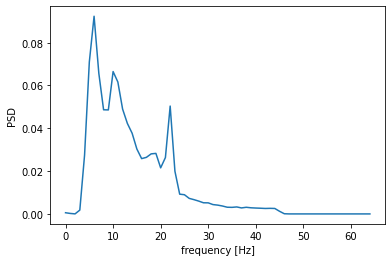

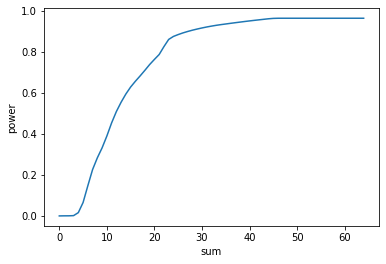

In [14]:
f, Pxx_den = signal.welch(all_data[0][0], fs=128, window='hann', nperseg = 128, noverlap=64) # one channel
plt.plot(f, Pxx_den)
plt.ylim()
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD')
plt.show()

y_int = integrate.cumtrapz(Pxx_den, f, initial=0)
plt.plot(f, y_int)
plt.ylim()
plt.xlabel('sum')
plt.ylabel('power')
plt.show()

In [15]:
def trial_psd_extraction2(data): # data shape (12, 7680)
    all_channels_psd = []
    
    for channel in data:
        f, Pxx_den = signal.welch(channel, fs=128, window='hann', nperseg = 128, noverlap=64)
        y_int = integrate.cumtrapz(Pxx_den, f, initial=0) # integrate to calculate band power
        channel_psd = np.array([y_int[7]-y_int[4],y_int[13]-y_int[8],y_int[30]-y_int[14],y_int[51]-y_int[31]])
        all_channels_psd.append(channel_psd)
    
    all_channels_psd = np.array(all_channels_psd)
    all_channels_psd = 100*all_channels_psd.reshape((32*4))

    return all_channels_psd

In [16]:
trial_psd_extraction2(all_data[0])

array([20.98797141, 27.11409795, 32.18193636,  4.25991267, 27.84813741,
       30.06121186, 36.48280336,  3.88975413, 31.33612216, 32.94840606,
       39.04454267,  4.39139243, 31.551009  , 36.1669754 , 31.48911951,
        5.36051545, 15.5243578 , 19.64571996, 16.57656258,  3.59752931,
       15.3029972 , 16.83444616, 20.21291608,  2.86443797, 16.69377201,
       23.69103638, 18.07509099,  3.60596935, 34.60630426, 38.07226073,
       41.66168882, 17.84945413, 12.99624101, 34.65991343, 20.07486904,
        4.26921253,  7.57254091, 18.32426534, 13.7675797 ,  1.72771009,
       32.87512864, 51.11381791, 28.17513858,  5.71246678, 22.53485164,
       53.84553412, 32.90166576, 10.38024335, 18.97507671, 64.5460392 ,
       25.79501213,  5.89472418, 23.7564234 , 46.76307492, 32.70509425,
       11.81796094, 25.21774446, 39.31332027, 24.96215728,  5.17582274,
       10.43360128, 29.11148138, 15.4065594 ,  1.82128414, 38.13643976,
       31.71529712, 33.1528522 ,  4.79309128, 27.88953734, 29.83

# 10-fold cross-validation

In [17]:
all_data, all_labels = shuffle(all_data, all_labels, random_state=0)
n = len(all_labels) # 1059
print(n)
fold_n = math.floor(n/10) # 105
print(fold_n)
all_data, all_labels = all_data[:10*fold_n], all_labels[:10*fold_n] # (1050, 32, 8064)  
print(all_data.shape)

1082
108
(1080, 32, 7680)


In [18]:
def process(test_fold_number):
    # train has 9 folds, test has 1 fold
    train_data = np.concatenate((all_data[:test_fold_number*fold_n], all_data[fold_n+test_fold_number*fold_n:]), axis=0)
    train_labels = np.concatenate((all_labels[:test_fold_number*fold_n], all_labels[fold_n+test_fold_number*fold_n:]), axis=0)
    test_data = all_data[test_fold_number*fold_n : fold_n+test_fold_number*fold_n]
    test_labels = all_labels[test_fold_number*fold_n : fold_n+test_fold_number*fold_n]
    print(train_data.shape,test_data.shape) # (945, 32, 8064) (105, 32, 8064)
    
    # -------- Feature extraction from 32 signal --------
    train_band_power = [] # band power feature sequence for train trials
    for data in train_data: # for every train trial
        trial_band_power = trial_psd_extraction2(data) # data shape (32, 8064)
        train_band_power.append(trial_band_power)
    train_band_power = np.array(train_band_power)

    test_band_power = [] # band power feature sequence for test trials
    for data in test_data: # for every test trial
        trial_band_power = trial_psd_extraction2(data) # data shape (32, 8064)
        test_band_power.append(trial_band_power)
    test_band_power = np.array(test_band_power)
    print("All features of training data shape: ", train_band_power.shape) # shape (953, 125, 128)
    print("All features of test data shape: ", test_band_power.shape) # shape (106, 125, 128)
    
    # -------- Create new SVM model --------
    from sklearn import svm
    from sklearn import metrics

    clf = svm.SVC(kernel='rbf')
    clf.fit(train_band_power, train_labels)
    
    filename = '../Results/SVM/SVM_model_test_fold_' + str(test_fold_number) + '.sav'
    pickle.dump(clf, open(filename, 'wb'))
    
    y_pred = clf.predict(test_band_power)
    print("Accuracy: ",metrics.accuracy_score(test_labels, y_pred))

In [19]:
for i in range(10):
    print("********** Test Fold " + str(i) + " ************")
    process(i)

********** Test Fold 0 ************
(972, 32, 7680) (108, 32, 7680)
All features of training data shape:  (972, 128)
All features of test data shape:  (108, 128)
Accuracy:  0.7129629629629629
********** Test Fold 1 ************
(972, 32, 7680) (108, 32, 7680)
All features of training data shape:  (972, 128)
All features of test data shape:  (108, 128)
Accuracy:  0.6944444444444444
********** Test Fold 2 ************
(972, 32, 7680) (108, 32, 7680)
All features of training data shape:  (972, 128)
All features of test data shape:  (108, 128)
Accuracy:  0.6388888888888888
********** Test Fold 3 ************
(972, 32, 7680) (108, 32, 7680)
All features of training data shape:  (972, 128)
All features of test data shape:  (108, 128)
Accuracy:  0.6203703703703703
********** Test Fold 4 ************
(972, 32, 7680) (108, 32, 7680)
All features of training data shape:  (972, 128)
All features of test data shape:  (108, 128)
Accuracy:  0.5925925925925926
********** Test Fold 5 ************
(972

# Test each section in process() function

In [47]:
test_fold_number = 1

# train has 9 folds, test has 1 fold
train_data = np.concatenate((all_data[:test_fold_number*fold_n], all_data[fold_n+test_fold_number*fold_n:]), axis=0)
train_labels = np.concatenate((all_labels[:test_fold_number*fold_n], all_labels[fold_n+test_fold_number*fold_n:]), axis=0)
test_data = all_data[test_fold_number*fold_n : fold_n+test_fold_number*fold_n]
test_labels = all_labels[test_fold_number*fold_n : fold_n+test_fold_number*fold_n]
print(train_data.shape,test_data.shape) # (945, 32, 8064) (105, 32, 8064)

(972, 32, 7680) (108, 32, 7680)


In [48]:
# -------- Feature extraction from 32 signal --------
train_band_power = [] # band power feature sequence for train trials
for data in train_data: # for every train trial
    trial_band_power = trial_psd_extraction2(data)
    train_band_power.append(trial_band_power)
train_band_power = np.array(train_band_power)

test_band_power = [] # band power feature sequence for test trials
for data in test_data: # for every test trial
    trial_band_power = trial_psd_extraction2(data) # data shape (32, 8064)
    test_band_power.append(trial_band_power)
test_band_power = np.array(test_band_power)
print("All features of training data shape: ", train_band_power.shape) # (945, 128)
print("All features of test data shape: ", test_band_power.shape) # (105, 128)

All features of training data shape:  (972, 128)
All features of test data shape:  (108, 128)


In [49]:
print(np.amax(train_band_power)) # max value
print(np.amin(train_band_power)) # min value

1546.5971751041402
0.0162455164955058


In [50]:
# -------- Create new SVM model --------
from sklearn import svm
from sklearn import metrics

clf = svm.SVC(kernel='rbf')
clf.fit(train_band_power, train_labels)
y_pred = clf.predict(test_band_power)
print("Accuracy: ",metrics.accuracy_score(test_labels, y_pred))

Accuracy:  0.6944444444444444
